In this tutorial, you will use `ParticleInCell` to model one of the simplest phenomena in
plasma physics: an electrostatic (or Langmuir) oscillation. This tutorial is part of a
series of examples that uses `ParticleInCell` to demonstrate the basic plasma physics
concepts that are covered in [Birdsall and Langdon's classic PIC textbook](@cite
birdsall2004).

A Langmuir oscillation occurs when a slab of charge in a uniform plasma is
displaced. The resulting charge density gradient creates a restoring force
that causes the displaced slab of charge to return to its original position.
But---just as in a classical pendulum oscillation---the momentum of the
charge carries it past its equilibrium point, creating an opposite charge
gradient, and a restoring force in the opposite direction. As a result, the
slab of charge oscillates around its equilibrium forever (at least in this
idealized model that ignores possible damping mechanisms).
For a plasma composed of a single mobile species $s$ with mass $m_s$ and charge
$q_s$, the frequency of this oscillation is given by
$$
\omega_{p,s} = \sqrt{\frac{n_s q_s^2}{\epsilon_0 m_s}}
$$
where $n_s$ is the number density of the plasma and $\epsilon_0$ is the permitivity of
free space. Notice that the plasma frequency has a $m_s^{-1/2}$ dependence, and thus the
lightest species (typically electrons) will dominate the dynamics of a plasma oscillation.
For this reason, we will only model the dynamics of the electrons in our simulation.

## Simulating a cold electron plasma
We begin by loading the `ParticleInCell` package. Additionally, we load `CairoMakie`
which is a backend for [`Makie`](https://makie.org) that can generate beautiful,
publication-quality graphics.

In [1]:
using ParticleInCell
using CairoMakie
CairoMakie.activate!(type = "svg") #hide
set_theme!(theme_light()) #hide

We begin by creating some electrons to move in the simulation. For even a tiny simulation
volume, there are *far* too many physical electrons to simulate each one individually.
Instead, PIC algorithms group physical particles into 'macroparticles'. The distribution
of macroparticles in phase space serves as an approximation for the phase space
distribution of physical particles. We arbitrarily choose a simulation domain of length
one, and a nominal electrons number density of $10^{14}$. Then, for a given number of
macroparticles, we can calculate the number of physical electrons represented by each.

In [2]:
sim_length = 1.0
number_density = 1e14
num_macroparticles = 320
particles_per_macro = number_density * sim_length / num_macroparticles

3.125e11

We distribute the macroparticles evenly across the simulation domain.

In [3]:
positions = collect(0:num_macroparticles-1) ./ num_macroparticles;

In order to seed a Langmuir oscillation, we give the electrons a sinusoidal velocity
perturbation. This corresponds to the moment in a Langmuir oscillation when the slab of
charge has reached equilibrium, but is being carried past by its momentum. This
perturbation is defined by a wavenumber `k` and an `amplitude`.

In [4]:
k = 1 * 2pi / sim_length
amplitude = 1e3
elec_mass = 9e-31
momentums = (particles_per_macro * elec_mass * amplitude) .* sin.(positions .* k);

We can visualize the initial condition of the electron macroparticle by plotting the
initial phase space.

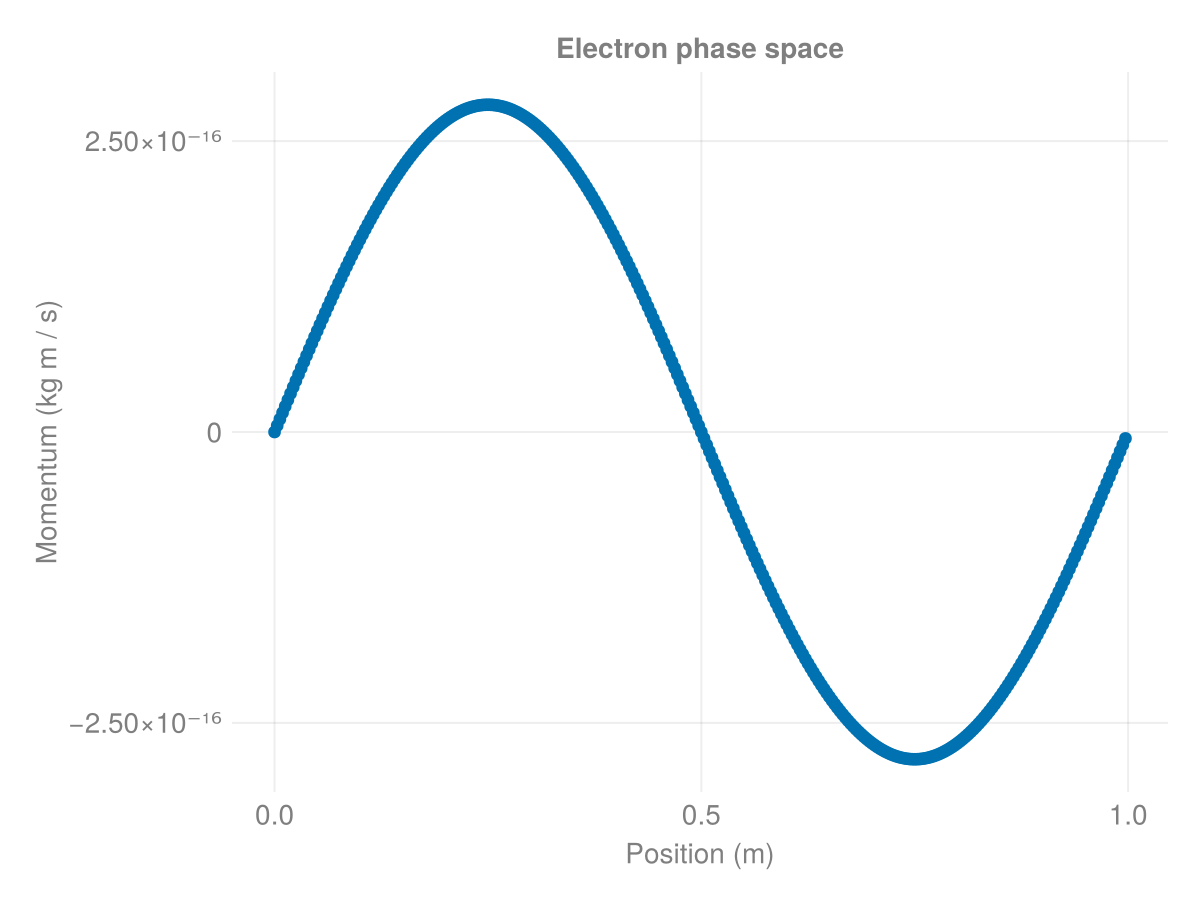

In [5]:
scatter(
    positions,
    momentums;
    axis = (;
        title = "Electron phase space",
        xlabel = "Position (m)",
        ylabel = "Momentum (kg m / s)",
    ),
)

Finally, we create a `VariableWeightSpecies` which holds the all of the
macroparticles. Additionally, we must pass the value of
`particles_per_macro`, which is used to calculate the charge and mass of the
macroparticles.

In [6]:
electrons = ParticleInCell.electrons(positions, momentums, particles_per_macro);

Now we address the 'cell' piece of particle-in-cell by creating a `grid`. Because Langmuir
oscillations are a one-dimensional phenomena, we will choose to perform a 1D simulation.

The choice of grid resolution is determined by the scale of the smallest relevant dynamics
begin simulated. For a Langmuir oscillation, the scale of the dynamics is set by `k`, and
so the simulation could likely accomplished with as few as 4 or 8 cells. However, this is
not a computationally demanding simulation, and so we arbitrarily choose to use 32 equally
spaced (i.e. uniform) grid points. Additionally, we make the simulation domain periodic.

In [7]:
num_cells = 32
dx = sim_length / num_cells
periodic = true
grid = UniformCartesianGrid((0.0,), (sim_length,), (num_cells,), (periodic,));

At this point, we must choose a timestep for the simulation. We would like to use a large
timestep so that more of the systems dynamics can be observed with the same number of
steps. However, we must resolve the fastest timescale of the dynamics that we are trying
to simulate. In this case, we must resolve the plasma frequency. Additionally, we must
choose a timestep that is short enough that particles do not cross more than one cell per
timestep to prevent numerical instabilities from arising. For the oscillation amplitude
that we have chosen, the particles do not move fast enough for the CFL condition to
matter, and so we will choose our timestep based on the expected plasma frequency.

In [8]:
epsilon_0 = 8.8e-12
elec_charge = 1.6e-19
elec_mass = 9e-31
expected_plasma_freq = sqrt(number_density * elec_charge^2 / elec_mass / epsilon_0)
expected_plasma_period = 2pi / expected_plasma_freq

1.1051531770007306e-8

Once again, this is not a computationally demanding simulation, and so we will choose a
relatively small timestep for improve numerical accuracy. You can play with increasing
the timestep, and see when the simulation results begin to deteriorate.

In [9]:
dt = 5e-11

5.0e-11

Now we need to set up the fields required for the electrostatic PIC simulation,
as well as specify the exact steps that will occur during each step..
To do this, we will use a helper function to create the fields and steps.

In [10]:
sim, fields = create_electrostatic_simulation(grid, [electrons], dt)

(Simulation(ParticleInCell.AbstractSimulationStep[ParticleInCell.ZeroField{Field{Float64, 1, 1, 2, UniformCartesianGrid{1, Float64, Int64}}}(Field(grid=UniformCartesianGrid{1, Float64, Int64}((0.0,), (1.0,), (32,), (true,)), offset=node,
num_elements=1, T=Float64), BSplineChargeInterpolation{VariableWeightSpecies{1, 1, Float64}, Field{Float64, 1, 1, 2, UniformCartesianGrid{1, Float64, Int64}}, typeof(ParticleInCell.bs_interp1)}(VariableWeightSpecies{1, 1, Float64}(StaticArraysCore.SVector{1, Float64}[[0.0], [0.003125], [0.00625], [0.009375], [0.0125], [0.015625], [0.01875], [0.021875], [0.025], [0.028125]  …  [0.96875], [0.971875], [0.975], [0.978125], [0.98125], [0.984375], [0.9875], [0.990625], [0.99375], [0.996875]], StaticArraysCore.SVector{1, Float64}[[0.0], [5.52197600455171e-18], [1.1041823182238048e-17], [1.6557413526896918e-17], [2.2066620673456393e-17], [2.7567320717688924e-17], [3.305739303501684e-17], [3.853472109805351e-17], [4.399719329256494e-17], [4.944270373153721e-17]

The variable `sim` holds the steps, and `fields` is a named tuple of the rho,
phi, and electric fields (actually two electric fields, one at the edge of each grid
cell, and one at the nodes). In this tutorial, we won't go over the details of the
PIC method, but you can find more details in the theory section of the manual.
However, we will need the nodal electric field later in the tutorial, so we assign
that field to its own variable.

In [11]:
Enode = fields[:Enode]

Field(grid=UniformCartesianGrid{1, Float64, Int64}((0.0,), (1.0,), (32,), (true,)), offset=node,
num_elements=1, T=Float64

Now we are ready to run the simulation. We will simulate the plasma for 1000
timesteps, and at each step, we will calculate the electric field energy,
$$
U_E = \int |E(x)|^2 \,\mathrm{d}x.
$$
This field energy will oscillate as the electrons move in and out of
equilibrium, and so we can use it to observe the Langmuir oscillation.

In [12]:
n_steps = 1000

electric_field_energy = Vector{Float64}(undef, n_steps)

for n = 1:n_steps
    # Calculate the electric field energy
    electric_field_energy[n] = 0
    for I in eachindex(Enode)
        electric_field_energy[n] += (dx * epsilon_0 / 2) * (Enode.values[I])^2
    end

    step!(sim)
end

We can now visualize the electric field energy to see the plasma oscillation.

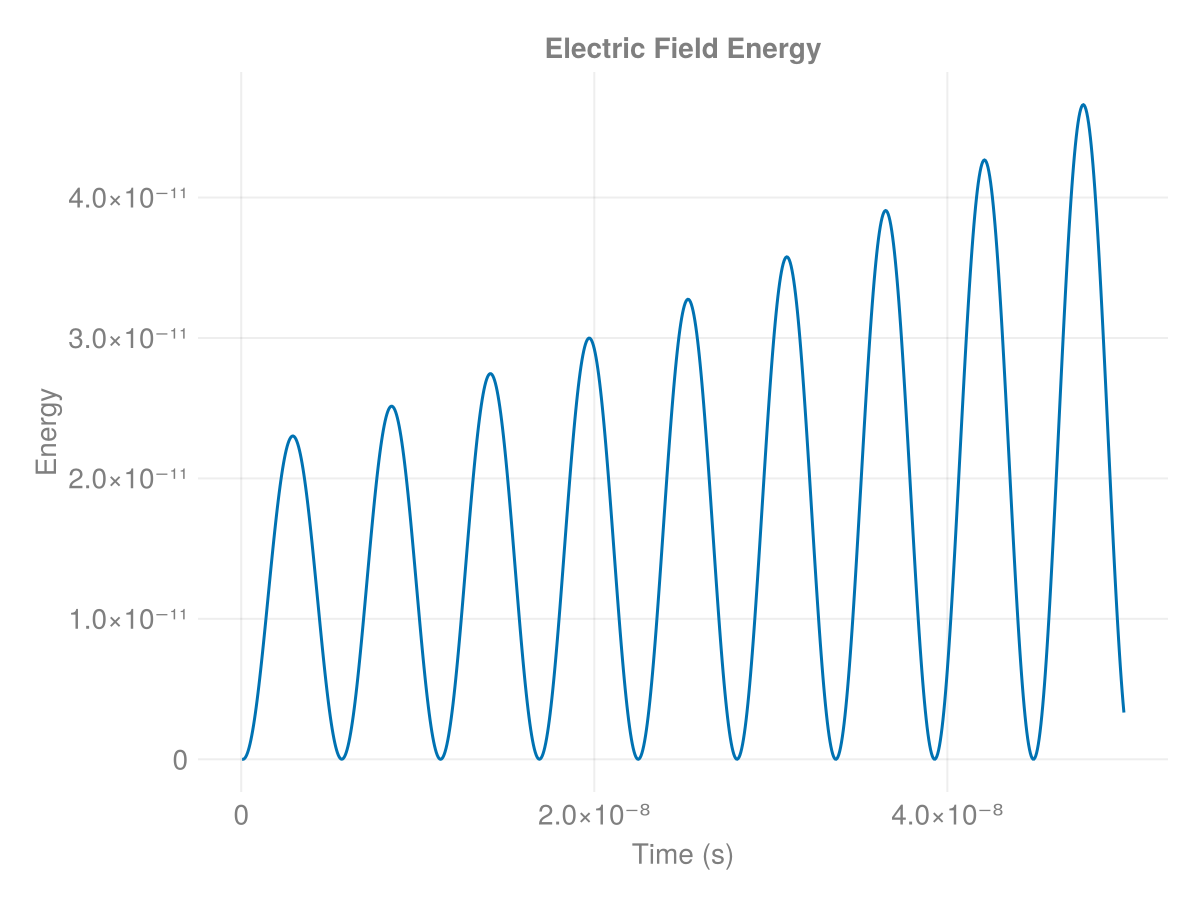

In [13]:
times = collect(range(1, n_steps)) .* dt
lines(
    times,
    electric_field_energy;
    axis = (; title = "Electric Field Energy", xlabel = "Time (s)", ylabel = "Energy"),
)

Notice that the electric field energy is slowly growing over time, which is
unphysical. We will discuss where this numerical instability comes from--
and how it can be avoided--later. But for now, we can still use the
electric-field-energy time series to calculate the plasma frequency. First,
let's plot the Fourier transform of the electric field energy.

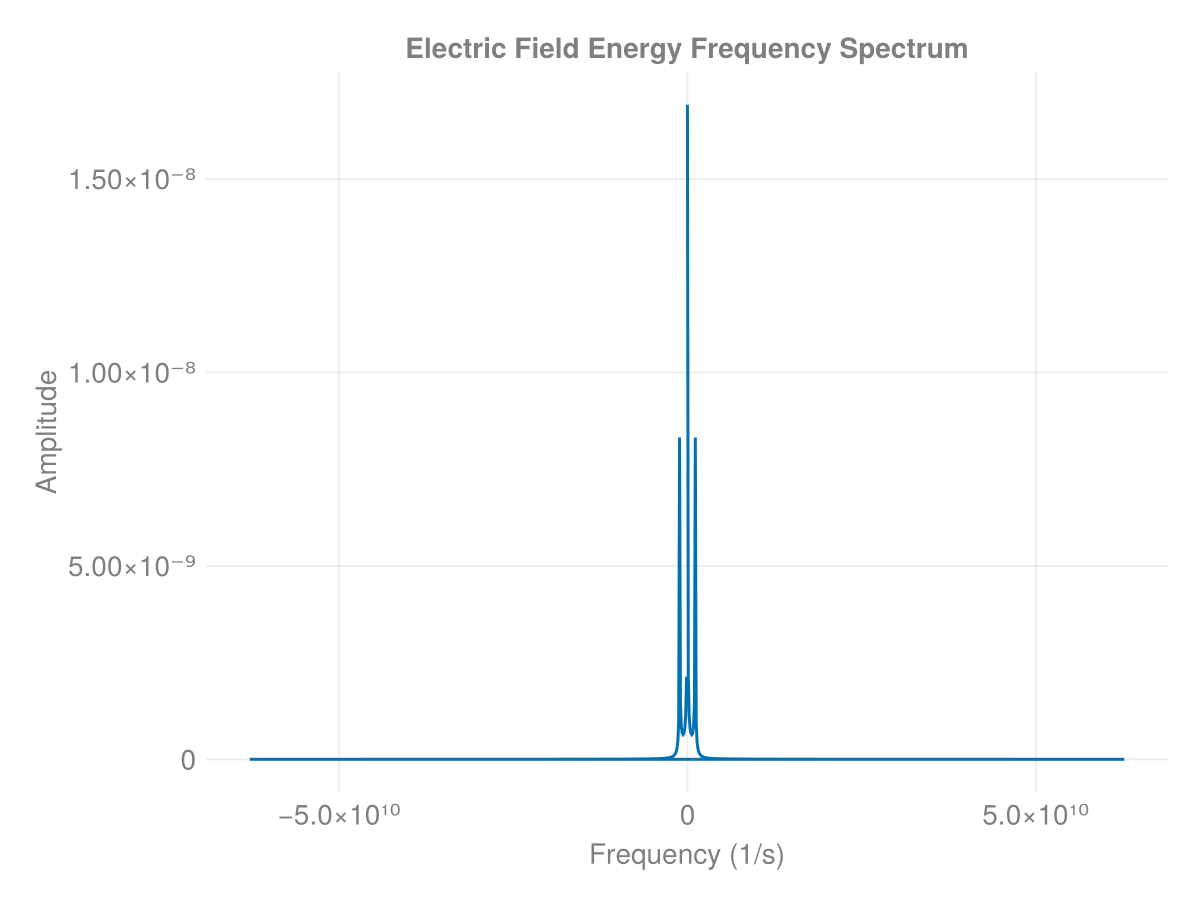

In [14]:
using FFTW

freqs = fftfreq(n_steps, 1 / dt) .* 2pi
freq_amps = abs.(fft(electric_field_energy))

lines(
    freqs,
    freq_amps;
    axis = (;
        title = "Electric Field Energy Frequency Spectrum",
        xlabel = "Frequency (1/s)",
        ylabel = "Amplitude",
    ),
)

It is hard to see what is happening at the low frequencies, so let's zoom
in on the positive low frequencies.

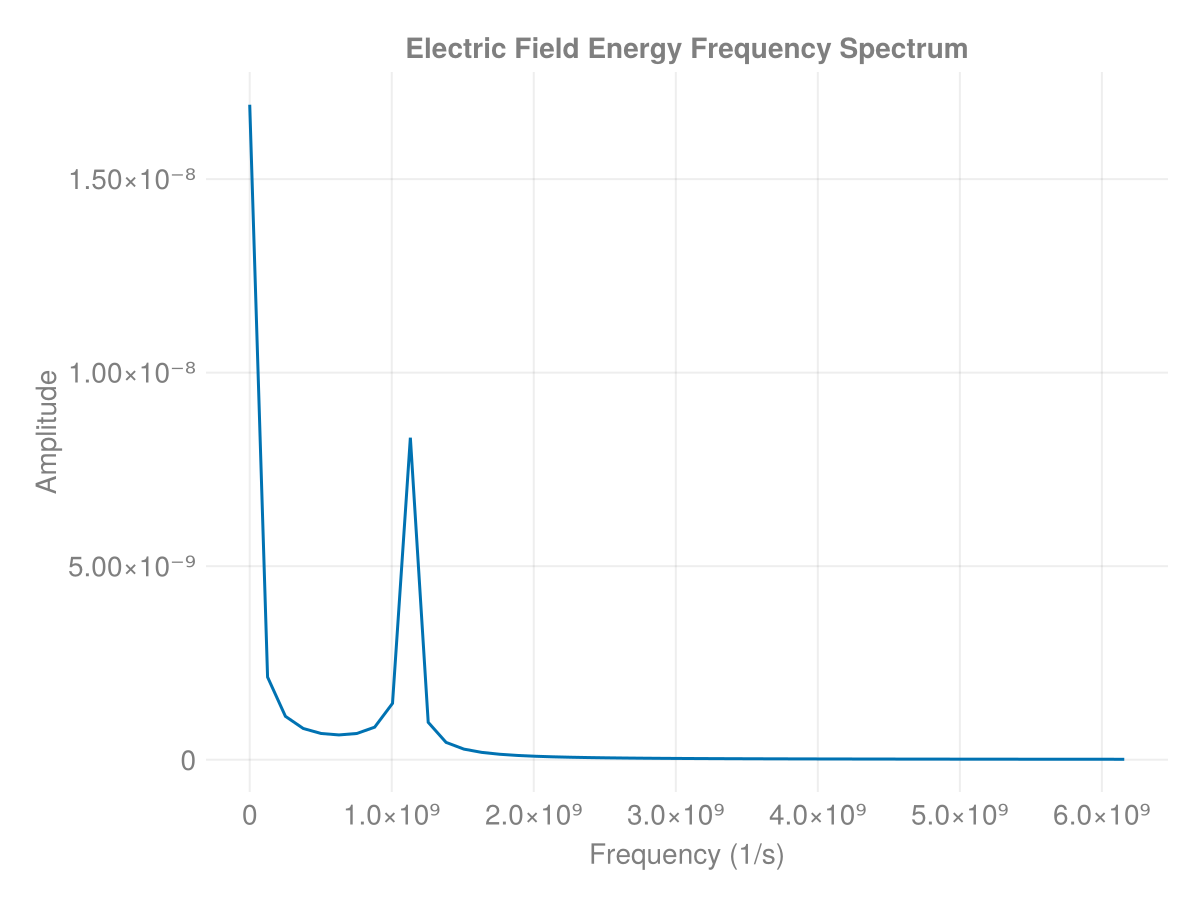

In [15]:
cutoff_index = round(Int, n_steps * 0.05)
lines(
    freqs[1:cutoff_index],
    freq_amps[1:cutoff_index];
    axis = (;
        title = "Electric Field Energy Frequency Spectrum",
        xlabel = "Frequency (1/s)",
        ylabel = "Amplitude",
    ),
)

Next, we find the maximum frequency. We don't care about the spike at zero frequency (that
is just a consequence of the electric field energy being a strictly positive quantity) so
we first set its amplitude to zero, and then find the largest remaining amplitude, and
it's corresponding frequency.

In [16]:
freq_amps[1] = 0
max_index = findmax(freq_amps)[2]
max_freq = freqs[max_index]

# Divide by 2 because the electric field energy goes through a maximum twice
# per plasma oscillation, and take the absolute value because we don't care
# about the phase of the oscillation.
plasma_freq = abs(max_freq / 2)

5.654866776461627e8

Finally, we can compare this to the theoretically expected result:

In [17]:
relative_error = (plasma_freq - expected_plasma_freq) / expected_plasma_freq

-0.005362140699342522

Less than 1% error. Not bad!

## Adding temperature to the plasma
In the previous simulation, the electric field energy grew unphysically throughout the
simulation. This was a result of the "grid-heating instability", which occurs when the
grid does not resolve the plasma Debye length, which for an electron plasma is given by
$$
\lambda_{D,e} = \sqrt{\frac{\epsilon_0 k_B T}{n_e q_e^2}},
$$
where $k_B$ is the Boltzmann constant and $T_e$ is the electron temperature.

When the Debye length of a plasma is underresolved, the plasma will unphysically heat,
causing the Debye length to grow until it is resolved by the grid. Many strategies have been
developed to mitigate this instability, but in this tutorial, we will simply give our plasma
sufficient thermal energy to begin so that the simulation will be stable against the
grid-heating instability.

Let's calculate the required electron temperature in the previous simulation so that
the 32 cell grid will resolve the Debye length. We set $\lambda_{D,e} = \Delta x$, and
solve for $T$ to find

In [18]:
boltzmann_constant = 1.381e-23
dx^2 * number_density * elec_charge^2 / epsilon_0 / boltzmann_constant

2.0571390955170825e7

Alternatively, we can express this temperature in terms of electron volts as

In [19]:
dx^2 * number_density * elec_charge / epsilon_0

1775.5681818181818

We will define a function that takes an electron density, electron temperature, and
oscillation wavenumber, and returns a measured plasma frequency.

In [20]:
function measure_plasma_frequency(number_density, temperature, wavenumber)
    sim_length = 1.0

    num_cells = 32
    dx = sim_length / num_cells

    num_macroparticles = 320
    particles_per_macro = number_density * sim_length / num_macroparticles

    perturb_amplitude = 1e3
    elec_mass = 9e-31
    boltzmann_constant = 1.381e-23
    thermal_velocity = sqrt(3 * boltzmann_constant * temperature / elec_mass)

    positions = collect(0:num_macroparticles-1) ./ num_macroparticles
    momentums =
        (particles_per_macro * elec_mass) .*
        (perturb_amplitude .* sin.(positions .* wavenumber) .+ thermal_velocity .* randn.())

    electrons = ParticleInCell.electrons(positions, momentums, particles_per_macro)

    grid = UniformCartesianGrid((0.0,), (sim_length,), (num_cells,), (true,))

    dt = 5e-11
    sim, fields = create_electrostatic_simulation(grid, [electrons], dt)
    Enode = fields[:Enode]

    n_steps = 1000
    electric_field_energy = Vector{Float64}(undef, n_steps)

    epsilon_0 = 8.8e-12
    for n = 1:n_steps
        # Calculate the electric field energy
        electric_field_energy[n] = 0
        for I in eachindex(Enode)
            electric_field_energy[n] += (dx * epsilon_0 / 2) * (Enode.values[I])^2
        end

        step!(sim)
    end

    freqs = fftfreq(n_steps, 1 / dt) .* 2pi
    freq_amps = abs.(fft(electric_field_energy))

    freq_amps[1] = 0
    max_index = findmax(freq_amps)[2]
    max_freq = freqs[max_index]
    plasma_freq = abs(max_freq / 2)

    return plasma_freq
end

measure_plasma_frequency (generic function with 1 method)

For a warm plasma, the thermal pressure acts as an additional restoring force on the
plasma oscillation. It can be show that the modified dispersion relation (frequency
response as a function of wavenumber) is given by
$$
\omega^2 = \omega_{p,e}^2 + \frac{3 k_B T_e}{m_e} k^2.
$$
Notice that when $T_e = 0$, the frequency is the plasma frequency, regardless
of the wavenumber.

Let's run a few simulations and verify that this relationship holds.

In [21]:
temperatures = [0, 0.1, 1, 10]
measure_plasma_frequency.(1e14, temperatures, 1 / 2 * pi)

4-element Vector{Float64}:
 5.654866776461627e8
 5.654866776461627e8
 6.2831853071795866e7
 5.654866776461627e8

We can compare this to the expected result.

In [22]:
function warm_plasma_freq(number_density, temperature, wavenumber)
    epsilon_0 = 8.8e-12
    elec_charge = 1.6e-19
    elec_mass = 9e-31
    boltzmann_constant = 1.381e-23
    square_plasma_freq = number_density * elec_charge^2 / elec_mass / epsilon_0
    correction_factor = boltzmann_constant * temperature * wavenumber^2 / elec_mass
    return sqrt(square_plasma_freq + correction_factor)
end
warm_plasma_freq.(1e14, temperatures, 1 / 2 * pi)

4-element Vector{Float64}:
 5.685352436149611e8
 5.685352436182908e8
 5.685352436482581e8
 5.685352439479299e8

Clearly, the restoring force of the pressure is not large enough to make a difference in this case.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*